In [ ]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from time import time
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
!unzip -q /content/gdrive/MyDrive/GANarchive.zip

In [ ]:
data_path = "/content/faces_dataset_small/*"

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
image_size = 128

# LOAD DATA

In [ ]:
class GenDataset(Dataset):
    def __init__(self, transform=None):
        self.images = [self.read_image(x) for x in sorted(glob(data_path))]
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def getimage(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image
    
    def read_image(self, path):
        x = cv2.imread(path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = Image.fromarray(x)
        return x

In [ ]:
image_tranform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
image_dataset = GenDataset(transform=image_tranform)

In [ ]:
def get_dataloader(image_size, batch_size, image_dataset):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    dataloader = DataLoader(dataset=image_dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [ ]:
train_dataloader = get_dataloader((image_size, image_size), 16, image_dataset)

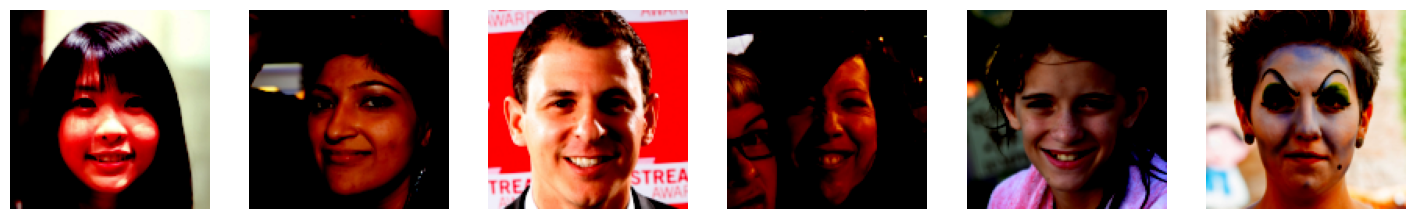

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(image_dataset.getimage(i).permute(1, 2, 0))

plt.show()

# INITIALIZE MODELS

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

# TRAIN MODELS

In [ ]:
def train_discriminator(model, optimizer, criterion, lr, epochs, dataloader):
    model['discriminator'].train()
    optimizer.zero_grad()

    real_preds = model['discriminator'](dataloader)
    real_targets = torch.sub(torch.ones_like(real_preds), 0.2)
    real_loss = criterion(real_preds, real_targets)

    lat = torch.randn(dataloader.size(0), latent_size, 1, 1, device=device)
    fake_imgs = model['generator'](lat).detach()

    fake_targets = torch.add(torch.zeros_like(real_preds), 0.2)
    fake_preds = model['discriminator'](fake_imgs)
    fake_loss = criterion(fake_preds, fake_targets)

    loss = real_loss + fake_loss
    loss.backwards()
    optimizer.step()

    return loss.item()

In [ ]:
def train_generator(model, optimizer, criterion, lr, epochs, dataloader):
    model['generator'].train()
    optimizer.zero_grad()

    lat = torch.randn(dataloader.size(0), latent_size, 1, 1, device=device)
    fake_imgs = model['generator'](lat)

    preds = model['discriminator'](fake_imgs)
    targets = torch.ones_like(preds)
    loss = criterion(preds, targets)

    loss.backwards()
    optimizer.step()

    return loss.item()

In [ ]:
def fit(model, criterion, epochs, lr, dataloader):
    model['generator'].train()
    model['discriminator'].train()

    optimizer_discriminator = torch.optim.Adam(model["discriminator"].parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(model["generator"].parameters(), lr=lr)

    history = {
        'discriminator': [],
        'generator': [],
        'real_scores': [],
        'fake_scores': []
    }

    for epoch in range(epochs):
        start = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        epoch_d_loss = []
        epoch_g_loss = []
        epoch_real_sc = []
        epoch_fake_sc = []
        for i, batch in enumerate(dataloader):
            batch = batch.to(device)

            loss_discriminator = train_discriminator(model, optimizer_discriminator, criterion['discriminator'], lr, epochs, batch)
            epoch_d_loss.append(loss_discriminator)

            loss_generator = train_generator(model, optimizer_generator, criterion['generator'], lr, epochs, batch)
            epoch_g_loss.append(loss_generator)

            epoch_real_sc.append(torch.mean(model["discriminator"](batch)).item())
            epoch_fake_sc.append(torch.mean(model["discriminator"](model["generator"](torch.randn(batch.size(0), latent_size, 1, 1, device=device)))).item())

        history['generator'].append(np.mean(epoch_g_loss))
        history['discriminator'].append(np.mean(epoch_d_loss))
        history['real_scores'].append(np.mean(epoch_real_sc))
        history['fake_scores'].append(np.mean(epoch_fake_sc))

        print("loss_generator: {:.4f}, loss_discriminator: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                history['generator'][-1], history['discriminator'][-1], history['real_scores'][-1], history['fake_scores'][-1]))
        end = time()
        print('Time: %f' % (end-start))
    return history

In [ ]:
history = fit(model, criterion, 30, lr, train_dataloader)

* Epoch 1/30

loss_generator: 1.9503, loss_discriminator: 1.1025, real_score: 0.7885, fake_score: 0.2388

Time: 29.140382

* Epoch 2/30

loss_generator: 1.8261, loss_discriminator: 1.0449, real_score: 0.7868, fake_score: 0.2243

Time: 27.764619

* Epoch 3/30

loss_generator: 1.7542, loss_discriminator: 1.0378, real_score: 0.7889, fake_score: 0.2166

Time: 27.894153

* Epoch 4/30

loss_generator: 1.6920, loss_discriminator: 1.0288, real_score: 0.7915, fake_score: 0.2156

Time: 28.121943

* Epoch 5/30

loss_generator: 1.6233, loss_discriminator: 1.1595, real_score: 0.7287, fake_score: 0.2905

Time: 28.228284

* Epoch 6/30

loss_generator: 1.5448, loss_discriminator: 1.1815, real_score: 0.7179, fake_score: 0.3140

Time: 28.222628

* Epoch 7/30

loss_generator: 1.4770, loss_discriminator: 1.1728, real_score: 0.7195, fake_score: 0.3176

Time: 28.162897

* Epoch 8/30

loss_generator: 1.5782, loss_discriminator: 1.1425, real_score: 0.7406, fake_score: 0.2866

Time: 28.277181

* Epoch 9/30

lo

# VISUALIZE RESULTS

In [ ]:
def plot_learning_curves(history, labels):
    loss = history[0]  
    val_loss = history[1]  
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label = labels[0])
    plt.plot(val_loss, label = labels[1])
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel(labels[2])
    plt.show()

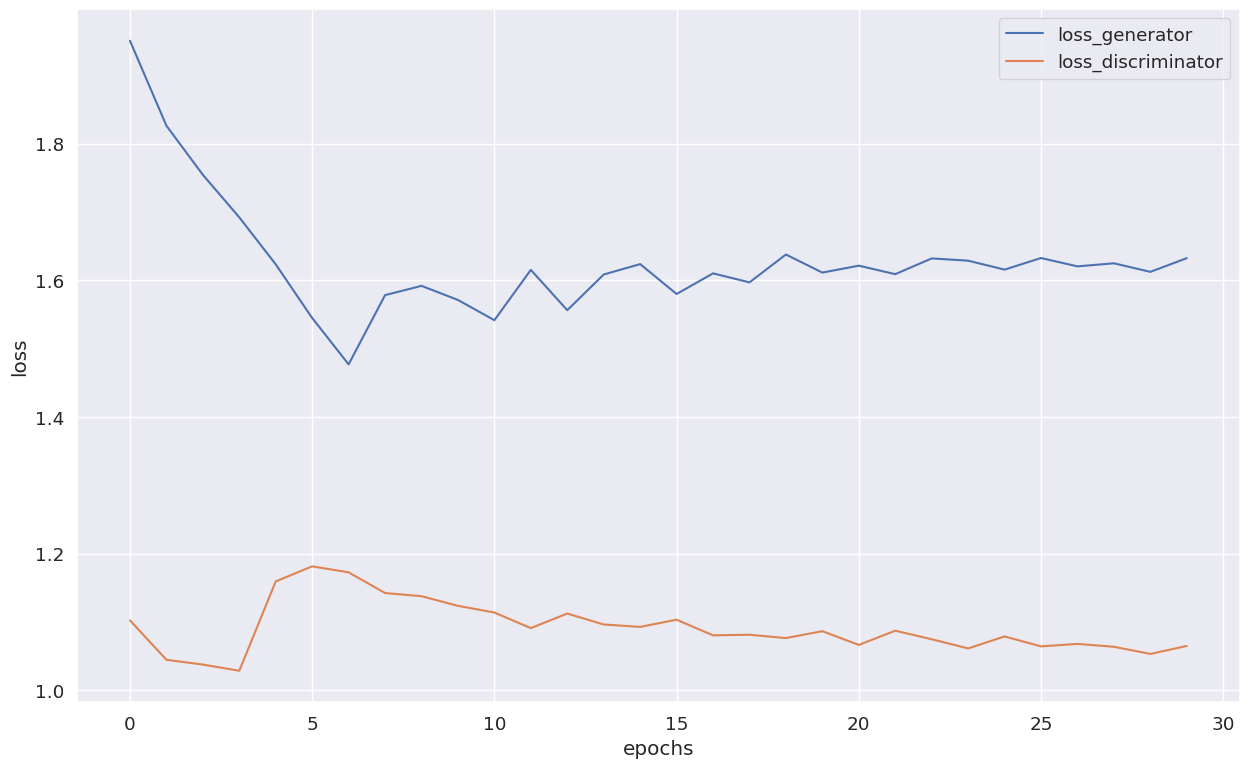

In [ ]:
plot_learning_curves((history['generator'], history['discriminator']), ["loss_generator", "loss_discriminator", "loss"])

It can be seen from the graphs that it makes no sense to continue training the model, because even after 8-10 epochs, the value of the loss function reaches a plateau

The target loss function value for the generator model is 0, indicating that the images it generates are realistic enough\
As for the discriminator, loss values we got can be explained in two ways: the discriminator has learned well to distinguish the generated images from the real ones, but the generator generates images poorly and confuses the discriminator poorly. That is why it is necessary to find a sufficient balance between the values ​​of the loss functions of the discriminator and the generator

It can be seen from the graph that up to 5th-7th epoch, there was a significant improvement in the performance of both models, but then the values ​​of the loss functions became more stable. Most likely, to achieve a better result, it is necessary to use more complex models for both the generator and the discriminator.

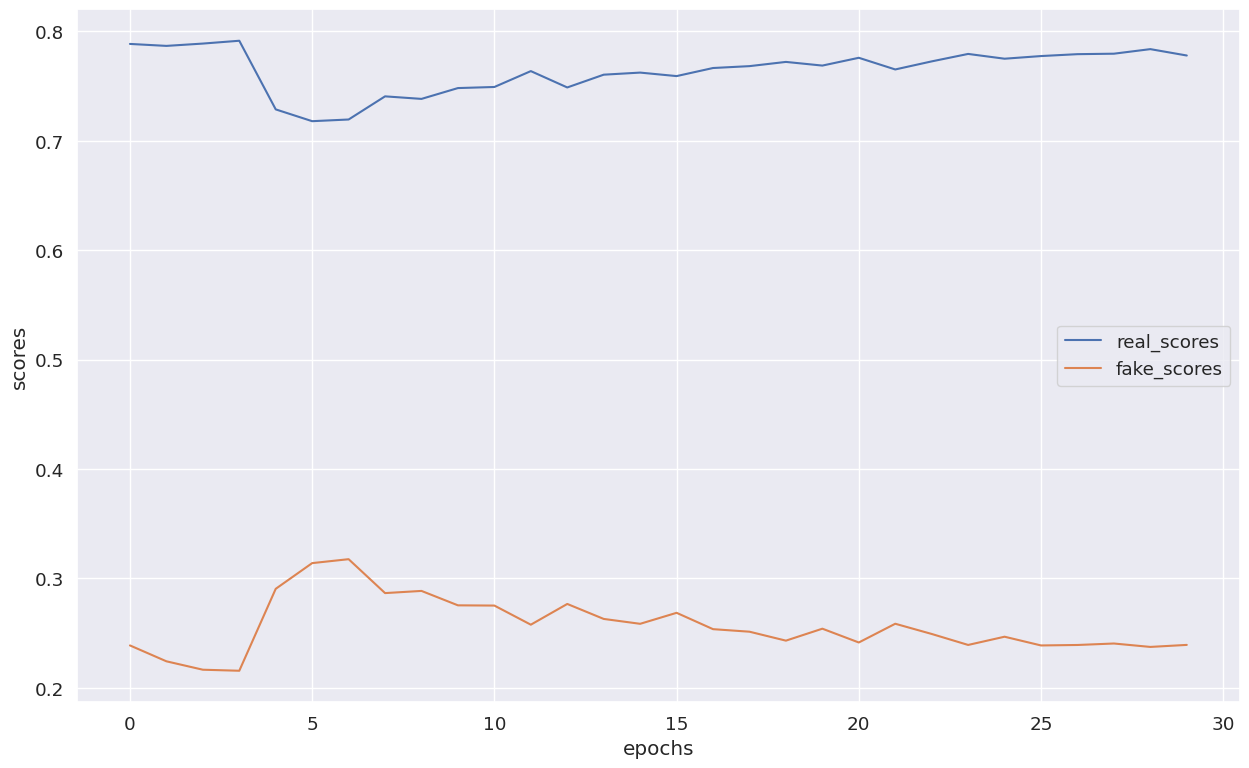

In [ ]:
plot_learning_curves((history['real_scores'], history['fake_scores']), ('real_scores', 'fake_scores', 'scores'))

The scores indicated on the graph show how well the discriminator distinguishes the image, where 
* 1 - the image is real
* 0 - the image is fake

Target values ​​for:
* real_scores - close to 1, which means that the discriminator correctly selects a real image\
* fake_scores is close to 0, which means
that the discriminator correctly separates the generated images

The last two graph images show the correlation between these metrics.

# EVALUATING RESULTS

In [ ]:
def generate_images(generator, num_images, latent_dim, device):
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, 1, 1, device=device)
        generated_images = generator(z).cpu().detach()
    return generated_images

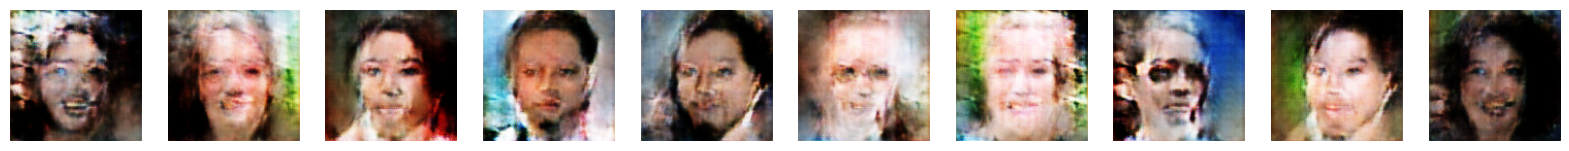

In [ ]:
num_images_to_generate = 10
generated_images = generate_images(model["generator"], num_images_to_generate, latent_size, device)

fig, axes = plt.subplots(1, num_images_to_generate, figsize=(20, 5))
for i in range(num_images_to_generate):
    axes[i].imshow((generated_images[i].permute(1, 2, 0) + 1) / 2)  
    axes[i].axis('off')
plt.show()


From the images generated above, you can see the basic outlines of human faces, but the background of these images, as well as the general picture of the faces, is unsatisfactory.

# Leave-one-out-1-NN classifier accuracy

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut

def get_real_images(train_dataloader, num_images):
    real_images = []
    for images in train_dataloader:
        real_images.extend(images.numpy())
        if len(real_images) >= num_images:
            break
    return real_images[:num_images]

num_images = 300
generated_images = generate_images(generator, num_images, latent_size, device)
real_images = get_real_images(train_dataloader, num_images)

X = torch.cat((generated_images, torch.tensor(real_images)), dim=0).view(num_images * 2, -1)
y = torch.cat((torch.zeros(num_images), torch.ones(num_images)))

/tmp/ipykernel_34/1977134543.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)

  X = torch.cat((generated_images, torch.tensor(real_images)), dim=0).view(num_images * 2, -1)


In [ ]:
res = cross_validate(KNeighborsClassifier(n_neighbors=1), X, y, cv=LeaveOneOut(), scoring='accuracy')

In [ ]:
accuracy = res['test_score'].mean()
accuracy

0.76475

The obtained result is 0.7647\
The desired result for such a problem is considered to be 0.5, which means that the model with a fairly equal probability distinguishes real and fake images correctly and NOT easily enough, which means that the generator confuses the model well enough. The result we obtained is quite good.

# VISUALIZE DISTRIBUTIONS

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=47)
all_images_2d = tsne.fit_transform(X)

/tmp/ipykernel_34/2135877147.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

  plt.scatter(all_images_2d[:, 0], all_images_2d[:, 1], c=y, cmap=plt.cm.get_cmap("coolwarm", 2), marker='.')


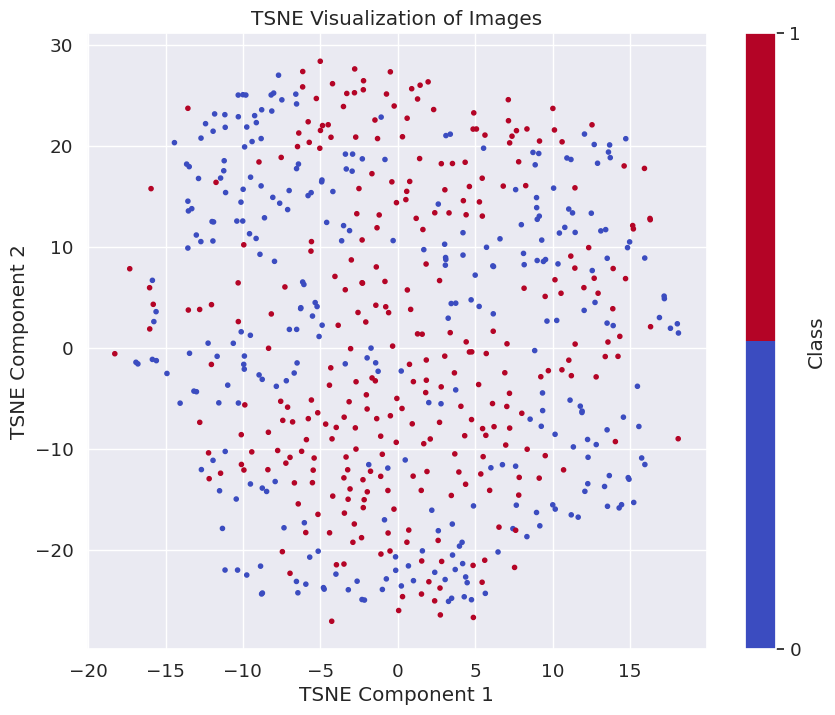

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(all_images_2d[:, 0], all_images_2d[:, 1], c=y, cmap=plt.cm.get_cmap("coolwarm", 2), marker='.')
plt.colorbar(ticks=range(2), label='Class')
plt.title('TSNE Visualization of Images')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

It can be seen from the image that the points of the classes are distributed on the plane approximately evenly, which is considered an ideal distribution result, from which we can conclude that the model worked relatively well.